## Check the GPU

In [1]:
!nvidia-smi

Wed Jun 10 21:21:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import libraries

In [0]:
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(101)

# tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Add, Softmax, GlobalMaxPool2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Input, ReLU, Lambda, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Renewed Batch Norm
from MBatchNorm import BatchNorm

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

# One Cycle LR
from clr import OneCycleLR

## Downloading Dataset

In [3]:
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


## View Data

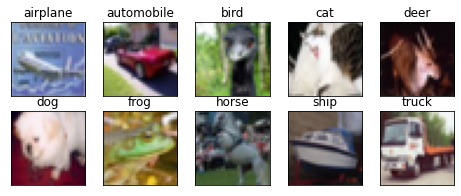

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Setting Hyperparams

In [0]:
hparams = {
    'learning_rate' : 0.4,  # fixed learning rate
    'batch_size' : 512,  # training batch size
    'momentum' : 0.9, # fixed momentum
    'n_epochs': 24,  # number of epochs to train
    'decay' : 1e-04 # learning rate*batch size
}

## Image Normalization and One hot encoding

In [0]:
#Image Normalization
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')

mean = np.mean(train_features, axis=(0,1,2))
std = np.std(train_features, axis=(0,1,2))
X_train = (train_features - mean) / (std)
X_test = (test_features - mean) / (std)

# convert class labels to binary class labels
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

## Image Augmentation techniques

* Random Crop of 32x32 with padding of 4px
* Horizontal Flip
* CutOut of 8x8


In [0]:
# Custom Image augmentation 

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

datagen = ImageDataGenerator(preprocessing_function=CustomImageDataGen)
datagen.fit(X_train)

## Network Architecture (ResNet 9)

In [0]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ResNet9(tf.keras.Model):
  def __init__(self, weight=0.2):
    super(ResNet9, self).__init__()
    self.conv1_b1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm1_b1 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu1_b1 = tf.keras.layers.ReLU()

    self.conv1_b2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm1_b2 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu1_b2 = tf.keras.layers.ReLU()
    self.pool1_b2 = tf.keras.layers.MaxPool2D()

    self.conv2_b2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm2_b2 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu2_b2 = tf.keras.layers.ReLU()

    self.conv3_b2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm3_b2 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu3_b2 = tf.keras.layers.ReLU()

    self.add1_b2 = tf.keras.layers.Add()

    self.conv1_b3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm1_b3 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu1_b3 = tf.keras.layers.ReLU()
    self.pool1_b3 = tf.keras.layers.MaxPool2D()

    self.conv2_b3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm2_b3 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu2_b3 = tf.keras.layers.ReLU()

    self.conv3_b3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm3_b3 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu3_b3 = tf.keras.layers.ReLU()

    self.add1_b3 = tf.keras.layers.Add()

    self.conv1_b4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer=init_pytorch, use_bias = False)
    self.batchnorm1_b4 = BatchNorm(momentum=0.9, epsilon=1e-5)
    self.relu1_b4 = tf.keras.layers.ReLU()
    self.pool1_b4 = tf.keras.layers.MaxPool2D()

    self.gap = tf.keras.layers.GlobalMaxPool2D()
    self.flatten = tf.keras.layers.Flatten()
    self.linear = tf.keras.layers.Dense(num_classes)
    self.weight = weight
    self.softmax = tf.keras.layers.Softmax()

  def call(self, input):
    """Run the model."""
    prep = self.relu1_b1(self.batchnorm1_b1(self.conv1_b1(input)))
    self.batch_mean1, self.batch_var1 = tf.nn.moments(self.conv1_b1(input), axes=list(range(self.conv1_b1(input).shape.ndims - 1)))

    layer1_part1 = self.pool1_b2(self.relu1_b2(self.batchnorm1_b2(self.conv1_b2(prep))))
    layer1_part2_res1 = self.relu2_b2(self.batchnorm2_b2(self.conv2_b2(layer1_part1)))
    layer1_part2_res2 = self.relu3_b2(self.batchnorm3_b2(self.conv3_b2(layer1_part2_res1)))
    self.batch_mean2, self.batch_var2 = tf.nn.moments(self.conv3_b2(layer1_part2_res1), axes=list(range(self.conv3_b2(layer1_part2_res1).shape.ndims - 1)))
    layer1 = self.add1_b2([layer1_part1, layer1_part2_res2])

    layer2_part1 = self.pool1_b3(self.relu1_b3(self.batchnorm1_b3(self.conv1_b3(layer1))))
    layer2_part2_res1 = self.relu2_b3(self.batchnorm2_b3(self.conv2_b3(layer2_part1)))
    layer2_part2_res2 = self.relu3_b3(self.batchnorm3_b3(self.conv3_b3(layer2_part2_res1)))
    layer2 = self.add1_b3([layer2_part1, layer2_part2_res2])

    layer3 = self.pool1_b4(self.relu1_b4(self.batchnorm1_b4(self.conv1_b4(layer2))))
    self.batch_mean3, self.batch_var3 = tf.nn.moments(self.conv1_b4(layer2), axes=list(range(self.conv1_b4(layer2).shape.ndims - 1)))

    flat = self.flatten(self.gap(layer3))
    self.fin = self.linear(flat) * self.weight
    result = self.softmax(self.fin)
    return result

model = ResNet9()

### With Original BatchNorm

In [0]:
y_pred = model(X_train[1:2,:,:,:])

In [11]:
model.summary()

Model: "res_net9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1728      
_________________________________________________________________
batch_norm (BatchNorm)       multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  73728     
_________________________________________________________________
batch_norm_1 (BatchNorm)     multiple                  512       
_________________________________________________________________
re_lu_1 (ReLU)               multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0  

In [0]:
mean_batch_first = []
std_batch_first = []
gamma_batch_first = []
beta_batch_first = []

gamma_batch_mid = []
beta_batch_mid = []
mean_batch_mid = []
std_batch_mid = []

mean_batch_last = []
std_batch_last = []
gamma_batch_last = []
beta_batch_last = []

class batch_print_callback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        global mean_batch_first
        global std_batch_first
        global gamma_batch_first
        global beta_batch_first
        mean_batch_first.append(model.batch_mean1.numpy())
        std_batch_first.append(tf.math.sqrt(model.batch_var1.numpy()+1e-05))
        gamma_batch_first.append(model.batchnorm1_b1.get_weights()[0])
        beta_batch_first.append(model.batchnorm1_b1.get_weights()[1])

        global mean_batch_mid
        global std_batch_mid
        global gamma_batch_mid
        global beta_batch_mid
        mean_batch_mid.append(model.batch_mean2.numpy())
        std_batch_mid.append(tf.math.sqrt(model.batch_var2.numpy()+1e-05))
        gamma_batch_mid.append(model.batchnorm3_b2.get_weights()[0])
        beta_batch_mid.append(model.batchnorm3_b2.get_weights()[1])

        global mean_batches_last
        global std_batches_last
        global gamma_batch_last
        global beta_batch_last
        mean_batch_last.append(model.batch_mean3.numpy())
        std_batch_last.append(tf.math.sqrt(model.batch_var3.numpy()+1e-05))
        gamma_batch_last.append(model.batchnorm1_b4.get_weights()[0])
        beta_batch_last.append(model.batchnorm1_b4.get_weights()[1])

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr= hparams['learning_rate'], momentum= hparams['momentum'],nesterov=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()],
              run_eagerly=True)

## Model Training 

### With Modified Batch_Norm

In [14]:
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams['learning_rate'],
                              batch_size = hparams['batch_size'],
                              samples = len(X_train),
                              epochs = hparams['n_epochs'],
                              maximum_momentum = hparams['momentum'],
                              verbose=False)
# train the model
start = time.time()

# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size= hparams['batch_size'], shuffle=True), 
                    epochs = hparams['n_epochs'], 
                    steps_per_epoch= np.ceil(X_train.shape[0]/hparams['batch_size']),
                    validation_data=(X_test, y_test),
                    callbacks = [lr_manager, batch_print_callback()],
                    verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 24s 243ms/step - loss: 1.3128 - categorical_accuracy: 0.5323 - val_loss: 1.0128 - val_categorical_accuracy: 0.6373
Epoch 2/24
98/98 [==============================] - 23s 237ms/step - loss: 0.7655 - categorical_accuracy: 0.7331 - val_loss: 0.7647 - val_categorical_accuracy: 0.7401
Epoch 3/24
98/98 [==============================] - 23s 239ms/step - loss: 0.5893 - categorical_accuracy: 0.7948 - val_loss: 0.9036 - val_categorical_accuracy: 0.7061
Epoch 4/24
98/98 [==============================] - 23s 237ms/step - loss: 0.4996 - categorical_accuracy: 0.8274 - val_loss: 0.6634 - val_categorical_accuracy: 0.7698
Epoch 5/24
98/98 [==============================] - 23s 238ms/step - loss: 0.4419 - categorical_accuracy: 0.8493 - val_loss: 0.5025 - val_categorical_accuracy: 0.8313
Epoch 6/24
98/98 [==============================] - 23s 239ms/step - loss: 0.3953 - categorical_accuracy: 0.8622 - val_loss: 0.6111 - val_categorical_accuracy: 0.802

## Mean, Std. Dev., Gamma and Beta variations of the first BN layer

### Single Channel Iterationwise updates

In [0]:
mean_block1 = [mean_batch_first[k][63]  for k in range(len(mean_batch_first))]
std_block1 = [std_batch_first[k][63]  for k in range(len(std_batch_first))]
gamma_block1 = [gamma_batch_first[k][63]  for k in range(len(gamma_batch_first))]
beta_block1 = [beta_batch_first[k][63]  for k in range(len(beta_batch_first))]

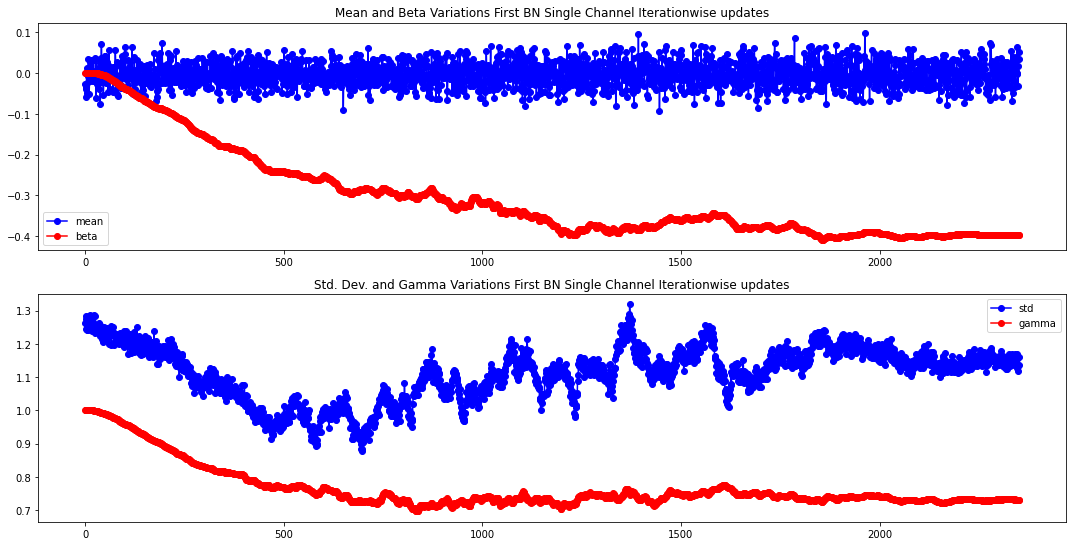

In [16]:
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(bottom=0.2)
ax1 = fig.add_subplot(411)
ax1.set_title("Mean and Beta Variations First BN Single Channel Iterationwise updates")
ax2 = fig.add_subplot(412)
ax2.set_title("Std. Dev. and Gamma Variations First BN Single Channel Iterationwise updates")
ax1.plot(mean_block1,'bo-',label='mean')
ax1.plot(beta_block1,'ro-',label='beta')
ax1.legend()
ax2.plot(std_block1,'bo-',label='std')
ax2.plot(gamma_block1,'ro-',label='gamma')
ax2.legend()
plt.tight_layout()

### Final iteration Every Channel updates

In [0]:
mean_block1 = model.batch_mean1.numpy()
std_block1 = tf.math.sqrt(model.batch_var1.numpy()+1e-05).numpy()
gamma_block1 = model.batchnorm1_b1.get_weights()[0]
beta_block1 = model.batchnorm1_b1.get_weights()[1]

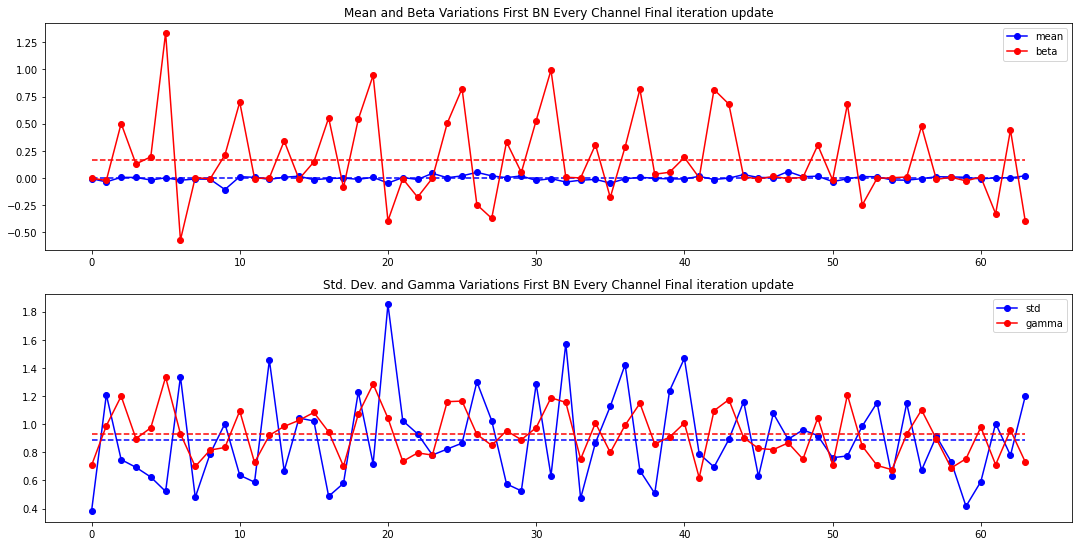

In [26]:
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(bottom=0.2)
ax1 = fig.add_subplot(411)
ax1.set_title("Mean and Beta Variations First BN Every Channel Final iteration update")
ax2 = fig.add_subplot(412)
ax2.set_title("Std. Dev. and Gamma Variations First BN Every Channel Final iteration update")
ax1.plot(mean_block1,'bo-',label='mean')
ax1.plot([np.mean(mean_block1)]*len(mean_block1), 'b--')
ax1.plot(beta_block1,'ro-',label='beta')
ax1.plot([np.mean(beta_block1)]*len(beta_block1), 'r--')
ax1.legend()
ax2.plot(std_block1,'bo-',label='std')
ax2.plot([np.mean(std_block1)]*len(std_block1), 'b--')
ax2.plot(gamma_block1,'ro-',label='gamma')
ax2.plot([np.mean(gamma_block1)]*len(gamma_block1), 'r--')
ax2.legend()
plt.tight_layout()

## Mean, Std. Dev., Gamma and Beta variations of the mid BN layer

### Single Channel Iterationwise updates

In [0]:
mean_block2 = [mean_batch_mid[k][127]  for k in range(len(mean_batch_mid))]
std_block2 = [std_batch_mid[k][127]  for k in range(len(std_batch_mid))]
gamma_block2 = [gamma_batch_mid[k][127]  for k in range(len(gamma_batch_mid))]
beta_block2 = [beta_batch_mid[k][127]  for k in range(len(beta_batch_mid))]

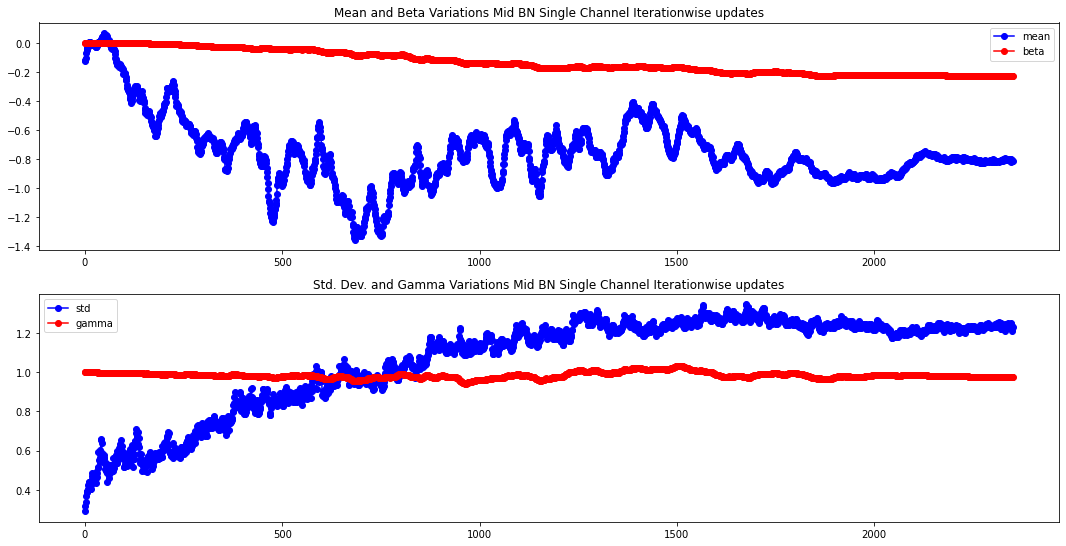

In [20]:
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(bottom=0.2)
ax1 = fig.add_subplot(411)
ax1.set_title("Mean and Beta Variations Mid BN Single Channel Iterationwise updates")
ax2 = fig.add_subplot(412)
ax2.set_title("Std. Dev. and Gamma Variations Mid BN Single Channel Iterationwise updates")
ax1.plot(mean_block2,'bo-',label='mean')
ax1.plot(beta_block2,'ro-',label='beta')
ax1.legend()
ax2.plot(std_block2,'bo-',label='std')
ax2.plot(gamma_block2,'ro-',label='gamma')
ax2.legend()
plt.tight_layout()

### Final iteration Every Channel updates

In [0]:
mean_block2 = model.batch_mean2.numpy()
std_block2 = tf.math.sqrt(model.batch_var2.numpy()+1e-05).numpy()
gamma_block2 = model.batchnorm3_b2.get_weights()[0]
beta_block2 = model.batchnorm3_b2.get_weights()[1]

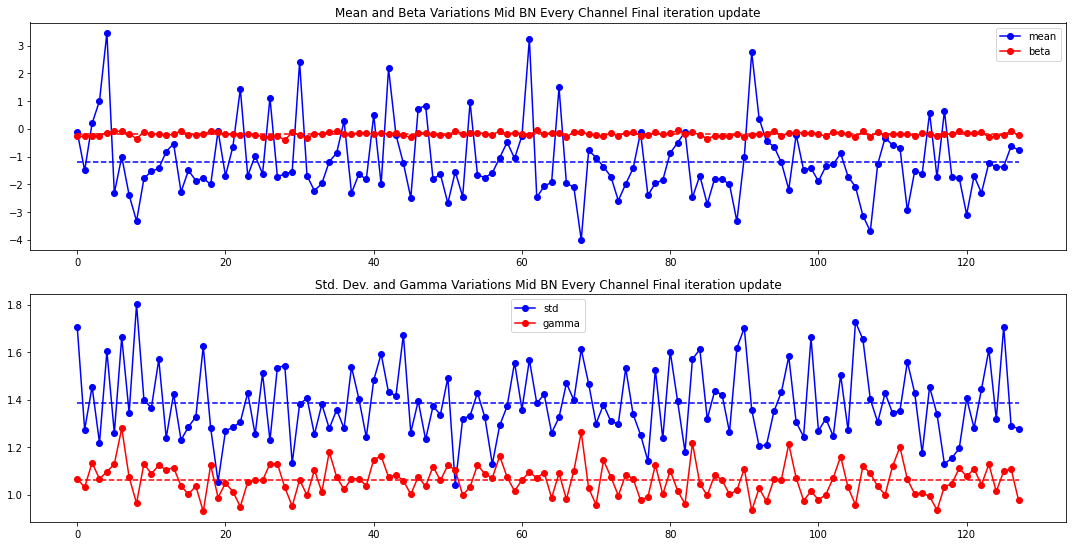

In [28]:
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(bottom=0.2)
ax1 = fig.add_subplot(411)
ax1.set_title("Mean and Beta Variations Mid BN Every Channel Final iteration update")
ax2 = fig.add_subplot(412)
ax2.set_title("Std. Dev. and Gamma Variations Mid BN Every Channel Final iteration update")
ax1.plot(mean_block2,'bo-',label='mean')
ax1.plot([np.mean(mean_block2)]*len(mean_block2), 'b--')
ax1.plot(beta_block2,'ro-',label='beta')
ax1.plot([np.mean(beta_block2)]*len(beta_block2), 'r--')
ax1.legend()
ax2.plot(std_block2,'bo-',label='std')
ax2.plot([np.mean(std_block2)]*len(std_block2), 'b--')
ax2.plot(gamma_block2,'ro-',label='gamma')
ax2.plot([np.mean(gamma_block2)]*len(gamma_block2), 'r--')
ax2.legend()
plt.tight_layout()

## Mean, Std. Dev., Gamma and Beta variations of the last BN layer

### Single Channel Iterationwise updates

In [0]:
mean_block4 = [mean_batch_last[k][255]  for k in range(len(mean_batch_last))]
std_block4 = [mean_batch_last[k][255]  for k in range(len(std_batch_last))]
gamma_block4 = [gamma_batch_last[k][255]  for k in range(len(gamma_batch_last))]
beta_block4 = [beta_batch_last[k][255]  for k in range(len(beta_batch_last))]

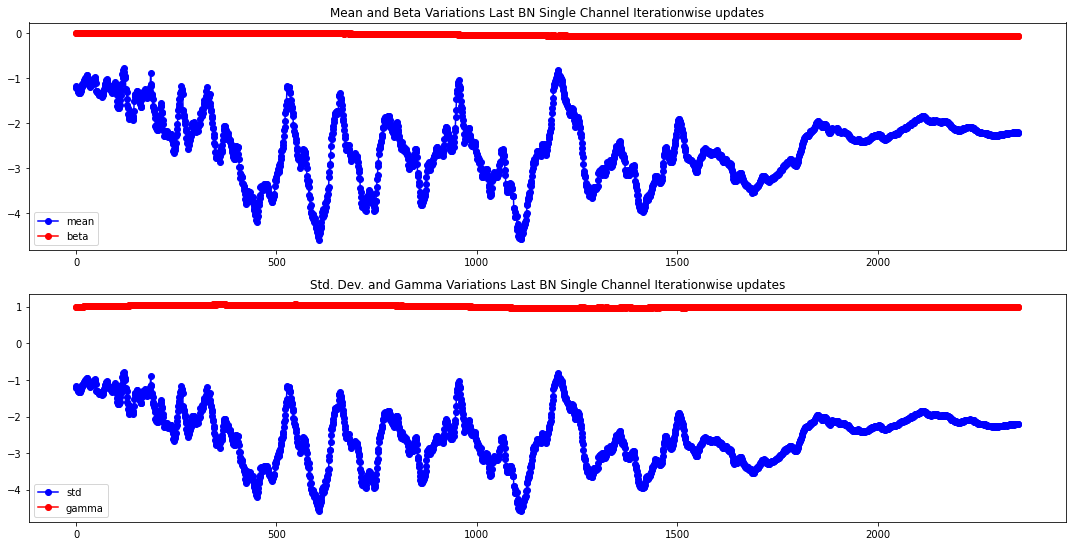

In [24]:
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(bottom=0.2)
ax1 = fig.add_subplot(411)
ax1.set_title("Mean and Beta Variations Last BN Single Channel Iterationwise updates")
ax2 = fig.add_subplot(412)
ax2.set_title("Std. Dev. and Gamma Variations Last BN Single Channel Iterationwise updates")
ax1.plot(mean_block4,'bo-',label='mean')
ax1.plot(beta_block4,'ro-',label='beta')
ax1.legend()
ax2.plot(std_block4,'bo-',label='std')
ax2.plot(gamma_block4,'ro-',label='gamma')
ax2.legend()
plt.tight_layout()

### Final iteration Every Channel updates

In [0]:
mean_block4 = model.batch_mean3.numpy()
std_block4 = tf.math.sqrt(model.batch_var3.numpy()+1e-05).numpy()
gamma_block4 = model.batchnorm1_b4.get_weights()[0]
beta_block4 = model.batchnorm1_b4.get_weights()[1]

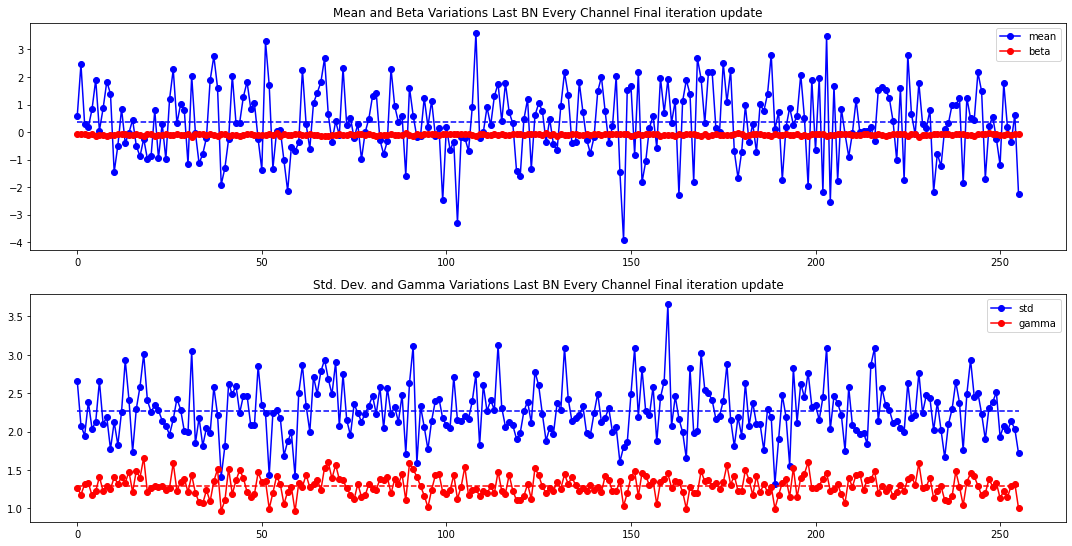

In [30]:
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(bottom=0.2)
ax1 = fig.add_subplot(411)
ax1.set_title("Mean and Beta Variations Last BN Every Channel Final iteration update")
ax2 = fig.add_subplot(412)
ax2.set_title("Std. Dev. and Gamma Variations Last BN Every Channel Final iteration update")
ax1.plot(mean_block4,'bo-',label='mean')
ax1.plot([np.mean(mean_block4)]*len(mean_block4), 'b--')
ax1.plot(beta_block4,'ro-',label='beta')
ax1.plot([np.mean(beta_block4)]*len(beta_block4), 'r--')
ax1.legend()
ax2.plot(std_block4,'bo-',label='std')
ax2.plot([np.mean(std_block4)]*len(std_block4), 'b--')
ax2.plot(gamma_block4,'ro-',label='gamma')
ax2.plot([np.mean(gamma_block4)]*len(gamma_block4), 'r--')
ax2.legend()
plt.tight_layout()

## Max Activation values before Softmax

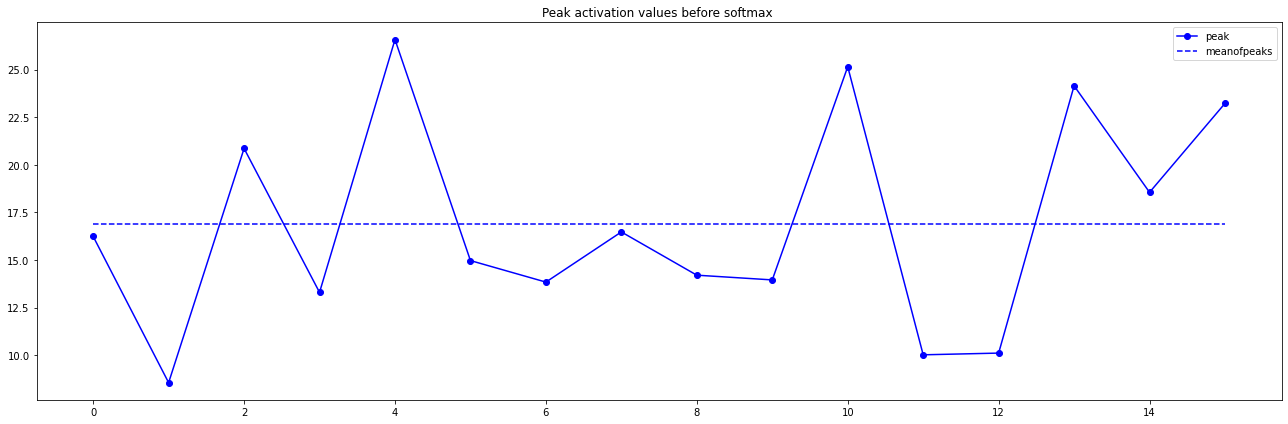

In [31]:
peak_act = [max(model.fin[i].numpy()) for i in range(len(model.fin))]

plt.figure(figsize = (18,6))
plt.title("Peak activation values before softmax ")
plt.plot(peak_act,'bo-',label='peak')
plt.plot([np.mean(peak_act)]*len(peak_act), 'b--', label='meanofpeaks')
plt.legend()
plt.tight_layout()

## Conclusion